#  Introduction to Gaussian Processes

In the world of cheminformatics and machine learning, models are often trees (random forest, XGBoost, etc.) or artifical neural networks (deep neural networks, graph convolutional networks, etc.). These models are known as "Frequentist" models. However, there is another category known as Bayesian models. Today we will be experimenting with a Bayesian model implemented in scikit-learn known as gaussian processes (GP). For a deeper dive on GP, there is a great [tutorial paper](https://arxiv.org/pdf/2009.10862.pdf) on how GP works for regression. There is also an [academic paper](https://doi.org/10.1002/cmdc.200700041) that applies GP to a real world problem.

As a short intro, GP allows us to build up our statistical model using an infinite number of Gaussian functions over our n-dimensional space, where n is the number of features. However, we pick these functions based on how well they fit the data we pass it. We end up with a statistical model built from an *ensemble* of Gaussian functions which can actually vary quite a bit. The result is that for points we have trained the model on, the variance in our ensemble should be very low. For test set points close to the training set points, the variance should be higher but still low as the ensemble was picked to predict well in its neighborhood. For points far from the training set points, however, we did not pick our ensemble of Gaussian functions to fit them so we'd expect the variance in our ensemble to be high. In this way, we end up with a statistical model that allows for a natural generation of uncertainty.

## Colab

This tutorial and the rest in the sequences are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Gaussian_Processes.ipynb)

## Setup

The first step is to get DeepChem up and running. We recommend using Google Colab to work through this tutorial series. You'll need to run the following commands to get DeepChem installed on your colab notebook.

In [1]:
%pip install --pre deepchem

## Gaussian Processes

As stated earlier, GP is already implemented in scikit-learn so we will be using DeepChem's scikit-learn wrapper. SklearnModel is a subclass of DeepChem's Model class. It acts as a wrapper around a sklearn.base.BaseEstimator.

Here we import deepchem and the GP regressor model from sklearn.

In [1]:
import deepchem as dc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import numpy as np
import matplotlib.pyplot as plt

## Loading data

Next we need a dataset that presents a regression problem. For this tutorial we will be using the BACE dataset from MoleculeNet.



In [2]:
tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer='ecfp', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

I always like to get a close look at what the objects in my code are storing. We see that tasks is a list of tasks that we are trying to predict. The transformer is a NormalizationTransformer that normalizes the outputs (y values) of the dataset.

In [3]:
print(f'The tasks are: {tasks}')
print(f'The transformers are: {transformers}')
print(f'The transformer normalizes the outputs (y values): {transformers[0].transform_y}')

The tasks are: ['pIC50']
The transformers are: [<deepchem.trans.transformers.NormalizationTransformer object at 0x7fc04401b190>]
The transformer normalizes the outputs (y values): True


Here we see that the data has already been split into a training set, a validation set, and a test set. We will train the model on the training set and test the accuracy of the model on the test set. If we were to do any hyperparameter tuning, we would use the validation set. The split was ~80/10/10 train/valid/test.

In [4]:
print(train_dataset)
print(valid_dataset)
print(test_dataset)

<DiskDataset X.shape: (1210, 1024), y.shape: (1210, 1), w.shape: (1210, 1), task_names: ['pIC50']>
<DiskDataset X.shape: (151, 1024), y.shape: (151, 1), w.shape: (151, 1), ids: ['Fc1ncccc1-c1cc(ccc1)C1(N=C(N)N(C)C1=O)c1cn(nc1)CC(CC)CC'
 'S1(=O)(=O)N(c2cc(cc3n(cc(CC1)c23)CC)C(=O)NC(Cc1ccccc1)C(=O)C[NH2+]C1CCOCC1)C'
 's1ccnc1-c1cc(ccc1)CC(NC(=O)[C@@H](OC)C)C(O)C[NH2+]C1CC2(Oc3ncc(cc13)CC(C)(C)C)CCC2'
 ...
 'S(=O)(=O)(Nc1cc(cc(c1)C(C)(C)C)C1([NH2+]CC(O)C(NC(=O)C)Cc2cc(F)cc(F)c2)CCCCC1)C'
 'O=C1N(C)C(=N[C@]1(c1cc(nc(c1)CC)CC)c1cc(ccc1)-c1cncnc1)N'
 'Clc1cc2CC(N=C(NC(Cc3ccccc3)C=3NC(=O)c4c(N=3)cccc4)c2cc1)(C)C'], task_names: ['pIC50']>
<DiskDataset X.shape: (152, 1024), y.shape: (152, 1), w.shape: (152, 1), ids: ['Clc1ccc(cc1)CC(NC(=O)C)C(O)C[NH2+]C1CC2(Oc3ncc(cc13)CC(C)(C)C)CCC2'
 'Fc1cc(cc(F)c1)CC(NC(=O)c1cc(cc(Oc2ccc(F)cc2)c1)C(=O)N(CCC)CCC)C(O)C[NH2+]Cc1cc(OC)ccc1'
 'O1c2c(cc(cc2)C2CCCCC2)C2(N=C(N)N(C)C2=O)CC1(C)C' ...
 'S(=O)(=O)(N(C)c1cc(cc(c1)COCC([NH3+])(Cc1ccccc1)C(F)F)C(=O)NC(C)c1

## Using the SklearnModel

Here we first create the model using the GaussianProcessRegressor we imported from sklearn. Then we wrap it in DeepChem's SklearnModel. To learn more about the model, you can either read the sklearn API or run help(GaussianProcessRegressor) in a code block.

As you see, the values I picked for the parameters seem awfully specific. This is because I needed to do some hyperparameter tuning beforehand to get model that wasn't wildly overfitting the training set. You can learn more about how I tuned the model in the Appendix at the end of this tutorial.

In [5]:
output_variance = 7.908735015054668
length_scale = 6.452349252677817
noise_level = 0.10475507755839343
kernel = output_variance**2 * RBF(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
alpha = 4.989499481123432e-09

sklearn_gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
model = dc.models.SklearnModel(sklearn_gpr)

Then we fit our model to the data and see how it performs both on the training set and on the test set. 

In [6]:
model.fit(train_dataset)
metric1 = dc.metrics.Metric(dc.metrics.mean_squared_error)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)
print(f'Training set score: {model.evaluate(train_dataset, [metric1, metric2])}')
print(f'Test set score: {model.evaluate(test_dataset, [metric1, metric2])}')

Training set score: {'mean_squared_error': 0.0457129375800123, 'r2_score': 0.9542870624199877}
Test set score: {'mean_squared_error': 0.20503945381118496, 'r2_score': 0.7850242035806018}


## Analyzing the Results

We can also visualize how well the predicted values match up to the measured values. First we need a function that allows us to obtain both the mean predicted value and the standard deviation of the value. This is done by sampling 100 predictions from each set of inputs X and calculating the mean and standard deviation.

In [7]:
def predict_with_error(dc_model, X, y_transformer):
    samples = model.model.sample_y(X, 100)
    means = y_transformer.untransform(np.mean(samples, axis=1))
    stds = y_transformer.y_stds[0] * np.std(samples, axis=1)

    return means, stds

For our training set, we see a pretty good correlation between the measured values (x-axis) and the predicted values (y-axis). Note that we use the transformer from earlier to untransform our predicted values.

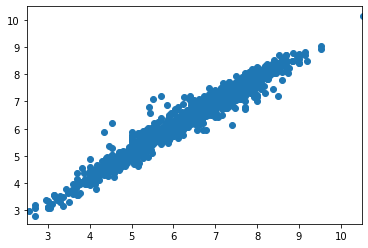

In [8]:
y_meas_train = transformers[0].untransform(train_dataset.y)
y_pred_train, y_pred_train_stds = predict_with_error(model, train_dataset.X, transformers[0])

plt.xlim([2.5, 10.5])
plt.ylim([2.5, 10.5])
plt.scatter(y_meas_train, y_pred_train)

We now do the same for our test set. We see a fairly good correlation! However, it is certainly not as tight. This is reflected in the difference between the R2 scores calculated above.

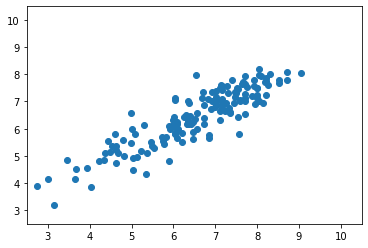

In [9]:
y_meas_test = transformers[0].untransform(test_dataset.y)
y_pred_test, y_pred_test_stds = predict_with_error(model, test_dataset.X, transformers[0])

plt.xlim([2.5, 10.5])
plt.ylim([2.5, 10.5])
plt.scatter(y_meas_test, y_pred_test)

We can also write a function to calculate how many of the predicted values fall within the predicted error range. This is done by counting up how many samples have a true error smaller than its standard deviation calculated earlier. One standard deviation is a 68% confidence interval.

In [10]:
def percent_within_std(y_meas, y_pred, y_std):
    assert len(y_meas) == len(y_pred) and len(y_meas) == len(y_std), 'length of y_meas and y_pred must be the same'

    count_within_error = 0
    for i in range(len(y_meas)):
        if abs(y_meas[i][0]-y_pred[i]) < y_std[i]:
            count_within_error += 1

    return count_within_error/len(y_meas)

For the train set, >90% of the samples are within a standard deviation. In comparison, only ~70% of the samples are within a standard deviation for the test set. A standard deviation is a 68% confidence interval so we see that for the training set, the uncertainty is close. However, this model overpredicts uncertainty on the training set.

In [11]:
percent_within_std(y_meas_train, y_pred_train, y_pred_train_stds)

0.9355371900826446

In [12]:
percent_within_std(y_meas_test, y_pred_test, y_pred_test_stds)

0.7368421052631579

We can also take a look at the distributions of the standard deviations for the test set predictions. We see a very roughly Gaussian distribution in the predicted errors.

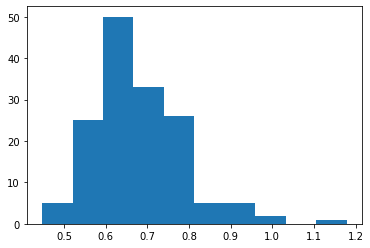

In [13]:
plt.hist(y_pred_test_stds)
plt.show()

For now, this is the end of our tutorial. We plan to follow up soon with a deeper dive into uncertainty estimation and in particular, calibrated uncertainty estimation. We will see you then!

## Appendix: Hyperparameter Optimization

As hyperparameter optimization is outside the scope of this tutorial, I will not explain how to use Optuna to tune hyperparameters. But the code is still included for the sake of completeness. 

In [ ]:
%pip install optuna
import optuna

In [ ]:
def get_model(trial):
    output_variance = trial.suggest_float('output_variance', 0.1, 10, log=True)
    length_scale = trial.suggest_float('length_scale', 1e-5, 1e5, log=True)
    noise_level = trial.suggest_float('noise_level', 1e-5, 1e5, log=True)

    params = {
        'kernel': output_variance**2 * RBF(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed'),
        'alpha': trial.suggest_float('alpha', 1e-12, 1e-5, log=True),
    }

    sklearn_gpr = GaussianProcessRegressor(**params)
    return dc.models.SklearnModel(sklearn_gpr)

def objective(trial):
    model = get_model(trial)
    model.fit(train_dataset)
    
    metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
    return model.evaluate(valid_dataset, [metric])['mean_squared_error']

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
print(study.best_params)

{'output_variance': 0.38974570882583015, 'length_scale': 5.375387643239208, 'noise_level': 0.0016265333497286342, 'alpha': 1.1273318360324618e-11}
